In [77]:
from ekpy import analysis
import numpy as np
import scipy.integrate as it
from scipy.signal import find_peaks, savgol_filter, peak_widths
import matplotlib.pyplot as plt

In [2]:
# load the dataset
dset = analysis.load_Dataset('./testnew')

# print dset, parsable collection of meta data which holds pointers to the real data files
dset

,initial_delay,pulse_delay,freq,voltage,capacitor_area,thickness,permittivity,amplification,format,type,points,count,x_increment,x_origin,x_reference,y_increment,y_origin,y_reference,trial,filename
0,0.00005,0.000005,10,0.5,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.005025,0.0,0,0,fe_pv__0.csv
1,0.00005,0.000005,10,1.0,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.010050,0.0,0,0,fe_pv__1.csv
2,0.00005,0.000005,10,1.5,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.015075,0.0,0,0,fe_pv__2.csv


In [3]:
data = dset.get_data()

In [279]:
type(data)

ekpy.analysis.core.Data

In [20]:
data2 = dset.query("voltage == 1").get_data()

In [21]:
data2.summary

{'initial_delay': {5e-05},
 'pulse_delay': {5e-06},
 'freq': {10},
 'voltage': {1.0},
 'capacitor_area': {4e-08},
 'thickness': {1e-08},
 'permittivity': {30},
 'amplification': {8},
 'format': {0},
 'type': {0},
 'points': {995},
 'count': {1},
 'x_increment': {4.72e-07},
 'x_origin': {2.71050543e-20},
 'x_reference': {0},
 'y_increment': {0.0100502502173185},
 'y_origin': {0.0},
 'y_reference': {0},
 'trial': {0}}

In [22]:
data2.data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c']

(<Figure size 640x480 with 1 Axes>, <Axes: >)

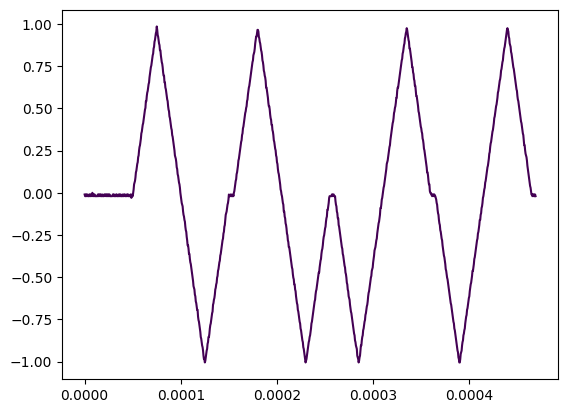

In [23]:
data2.plot(x='time_v', y='wfm_v')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

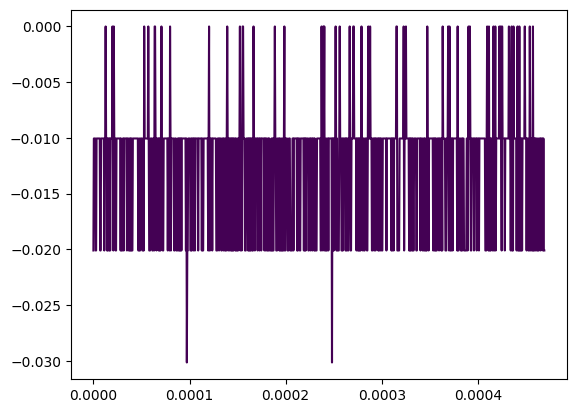

In [24]:
data2.plot(x='time_c', y='wfm_c')

use data.definition (no parenthesis) to get all the meta data associated with the exp for all trials in the dset

We may need to normalize the data for the wfm c to 0, aka shift it correspondingly. not sure why since it should be doing that but I will have to think about it

In [16]:
type(data2) #this is already a numpy array lets fucking gooo

ekpy.analysis.core.Data

In [ ]:
data['time_v']

In [ ]:
data.iloc[0].plot(x='time_v', y='wfm_v')

In [ ]:
data.plot()

In [25]:
def generate_q_wfm(data_dict) -> 'dict':
    wfm_q = it.cumulative_trapezoid(data_dict['wfm_c'], data_dict['time_c'], initial=0) 
    data_dict['wfm_q'] = wfm_q
    return data_dict

In [33]:
def generate_q_wfm_wrong(data_dict) -> 'dict':
    wfm_q = it.cumulative_trapezoid(data_dict['wfm_v'], data_dict['time_v'], initial=0) 
    data_dict['wfm_q_wrong'] = wfm_q
    return data_dict

In [30]:
newwwwww = data2.apply(generate_q_wfm)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

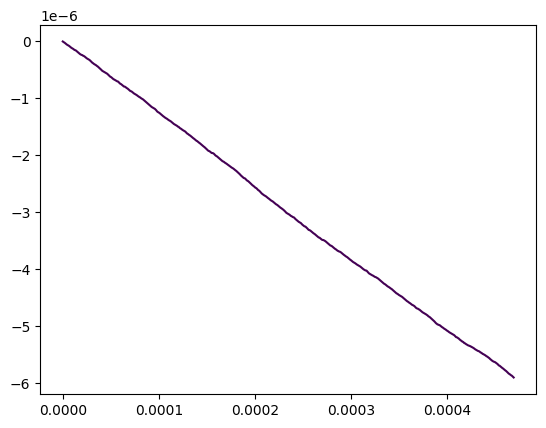

In [31]:
newwwwww.plot(x='time_c', y='wfm_q') #IT WORKS!!

In [162]:
wrong = data2.apply(generate_q_wfm_wrong)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

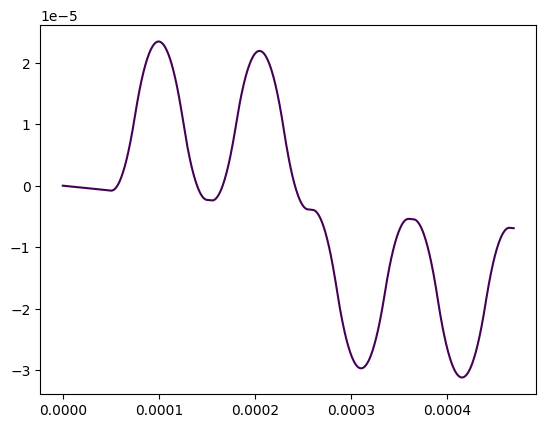

In [163]:
wrong.plot(x='time_v', y='wfm_q_wrong')

Now we need to convert this to polarization plot vs voltage. We are using the derivative of the waveform to essentially find out when the wavefoprm starts and ends
1. First take derivative of wfm
2. Then find points where it starts

In [164]:
def derivative(data_dict)->'dict':
    wfm_int = np.gradient(data_dict['wfm_v'], data_dict['time_v'])
    #add smoothing?
    wfm_int_smooth = savgol_filter(wfm_int, 51, 3)
    #normalize values to 1
    wfm_int_smooth_norm =  2 * ((wfm_int_smooth - np.min(wfm_int_smooth)) / (np.max(wfm_int_smooth) - np.min(wfm_int_smooth))) - 1
    data_dict['wfm_int'] = wfm_int_smooth_norm
    return data_dict

In [165]:
wrong2 = wrong.apply(derivative) #bruh why did i call it wfm_int its not an integral lmfaooo, wrong 2 is useless in the grandscheme of things

(<Figure size 640x480 with 1 Axes>, <Axes: >)

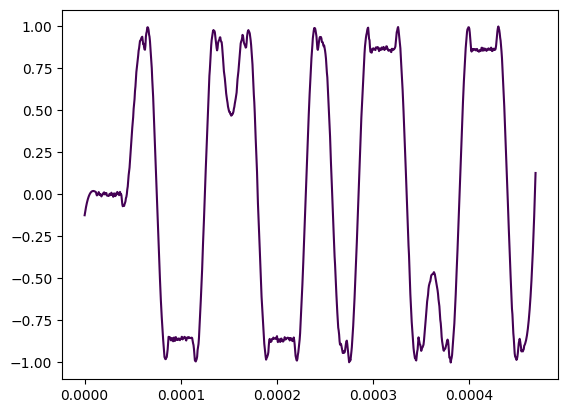

In [57]:
wrong2.plot(x='time_v', y='wfm_int')

MAKE A FUNCTION CALLED VISUALIZE ANALYSIS THAT DOES EACH STEP OF THE PROCESS AND PLOTS SEQUENTIALLY WITH APPROPIATE CAPTIONS (TITLES)

NEW METHOD, USE FINDPEAKS AND FINDTROUGHS (FIND PEAKS OF INVERTED DATASET) AND THAT IS EQUAL TO HALF OF THE TOTAL PULSE LENGTH AND JUST USE THAT TO FIND THE START AND END!

In [168]:
def find_peaks_troughs_index(data_dict)->'dict':
    arr = data_dict['wfm_v']
    arr_normalized = 2 * ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) - 1
    peaks, _ = find_peaks(arr_normalized, height=0.8)
    troughs, _ = find_peaks(-1*arr_normalized, height=0.8)
    all_peaks = np.concatenate((peaks, troughs), axis=0)
    #results_full = peak_widths(arr_normalized, peaks, rel_height=1)
    #data_dict['results_full'] = results_full
    data_dict['peaks'] = np.sort(all_peaks)
    return data_dict
    

In [169]:
wrong3 = wrong2.apply(find_peaks_troughs_index)

In [170]:
wrong3['peaks']

array([159, 265, 381, 487, 604, 710, 826, 932], dtype=int64)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

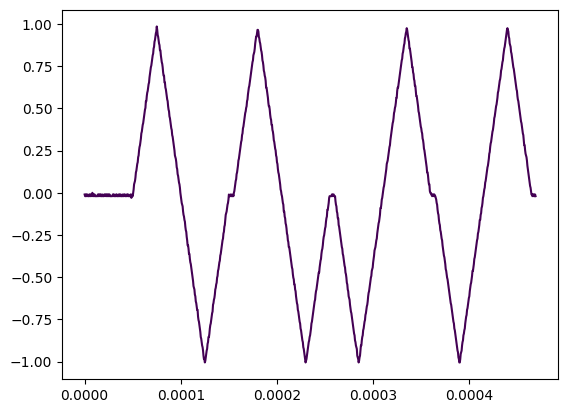

In [83]:
wrong3.plot(x='time_v', y='wfm_v')

In [171]:
def start_and_end_pulse(data_dict)->'dict':
    x = data_dict['peaks']
    counter = 0
    green_points = []
    while counter <(len(x)):
        half_pulse_len = x[counter+1] - x[counter]
        quarter_pulse_len = half_pulse_len/2
        start_of_pulse = x[counter] - quarter_pulse_len
        end_of_pulse = x[counter+1] + quarter_pulse_len
        green_points.append(int(start_of_pulse))
        green_points.append(int(end_of_pulse))
        counter +=2
    data_dict['start_and_end_pulse'] = green_points
    return data_dict
    

In [172]:
wrong4 = wrong3.apply(start_and_end_pulse)

In [173]:
wrong4['start_and_end_pulse']

array([106, 318, 328, 540, 551, 763, 773, 985])

In [174]:
wrong4.data_keys

['time_v',
 'wfm_v',
 'time_c',
 'wfm_c',
 'wfm_q_wrong',
 'wfm_int',
 'peaks',
 'start_and_end_pulse']

[159 265 381 487 604 710 826 932]
[106, 318, 328, 540, 551, 763, 773, 985]


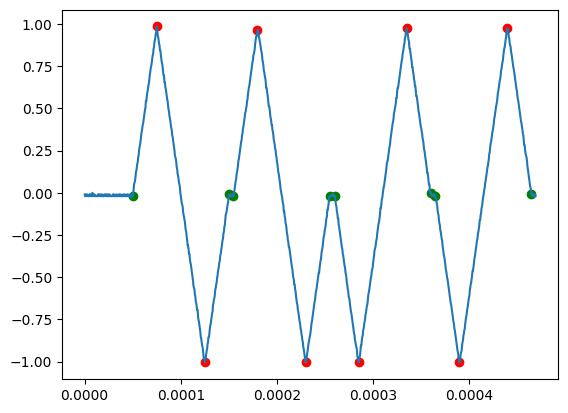

In [126]:
x = wrong3['peaks']
print(x)
green_points = []
counter = 0
while counter <(len(x)):
    half_pulse_len = x[counter+1] - x[counter]
    quarter_pulse_len = half_pulse_len/2
    start_of_pulse = x[counter] - quarter_pulse_len
    end_of_pulse = x[counter+1] + quarter_pulse_len
    green_points.append(int(start_of_pulse))
    green_points.append(int(end_of_pulse))
    counter +=2
print(green_points)
#witdthss = wrong3['results_full']
#widthsfixed = (np.array([109.5, 222. , 222. , 108. ]), np.array([-0.02020202, -1.        , -1.        , -0.01010101]), np.array([103., 265., 604., 879.]), np.array([212.5, 487. , 826. , 987. ]))
plt.scatter(wrong3['time_v'][x], wrong3['wfm_v'][x], color='red') #need to use a hieght
#plt.hlines(*widthsfixed[1:], color='C2')
plt.scatter(wrong3['time_v'][green_points], wrong3['wfm_v'][green_points], color='green')
plt.plot(wrong3['time_v'], wrong3['wfm_v'])

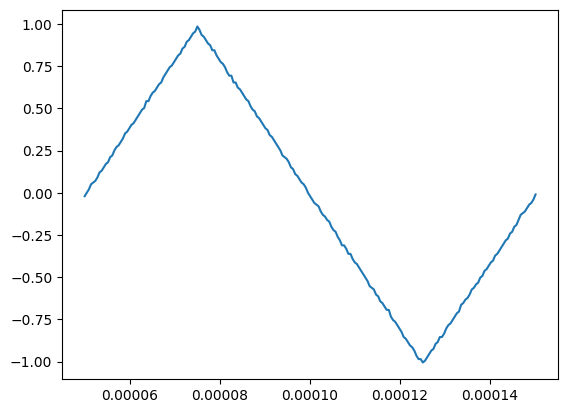

In [127]:
plt.plot(wrong3['time_v'][green_points[0]:green_points[1]+1], wrong3['wfm_v'][green_points[0]:green_points[1]+1])

In [175]:
wrong4.data_keys

['time_v',
 'wfm_v',
 'time_c',
 'wfm_c',
 'wfm_q_wrong',
 'wfm_int',
 'peaks',
 'start_and_end_pulse']

In [177]:
x1 = wrong4['wfm_v'][wrong4['start_and_end_pulse'][0]:wrong4['start_and_end_pulse'][1]+1]
y1 = wrong4['wfm_q_wrong'][wrong4['start_and_end_pulse'][0]:wrong4['start_and_end_pulse'][1]+1]

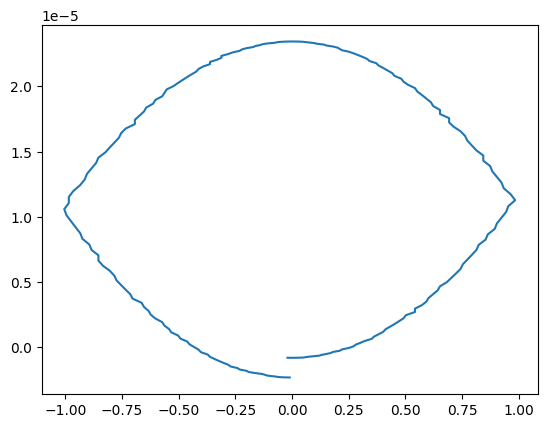

In [178]:
plt.plot(x1,y1)

In [179]:
x2 = wrong4['wfm_v'][wrong4['start_and_end_pulse'][2]:wrong4['start_and_end_pulse'][3]+1]
y2 = wrong4['wfm_q_wrong'][wrong4['start_and_end_pulse'][2]:wrong4['start_and_end_pulse'][3]+1]

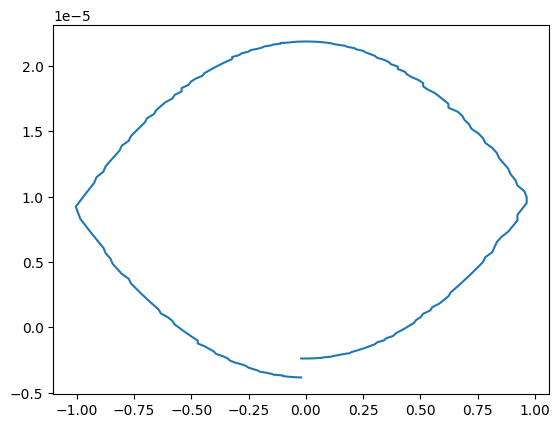

In [180]:
plt.plot(x2,y2)

In [182]:
print(data2.data_keys)
print(wrong.data_keys)
print(wrong2.data_keys)
print(wrong3.data_keys)
print(wrong4.data_keys)

['time_v', 'wfm_v', 'time_c', 'wfm_c']
['time_v', 'wfm_v', 'time_c', 'wfm_c', 'wfm_q_wrong']
['time_v', 'wfm_v', 'time_c', 'wfm_c', 'wfm_q_wrong', 'wfm_int']
['time_v', 'wfm_v', 'time_c', 'wfm_c', 'wfm_q_wrong', 'wfm_int', 'peaks']
['time_v', 'wfm_v', 'time_c', 'wfm_c', 'wfm_q_wrong', 'wfm_int', 'peaks', 'start_and_end_pulse']


In [184]:
wrong4.to_ekpdat('./test69') #saves data when ur working, good to know to add lmao

In [313]:
"""
Here I will make a helper funciton that takes in a doc string and returns what funciton it appends based on the format
"""

'\nHere I will make a helper funciton that takes in a doc string and returns what funciton it appends based on the format\n'

In [312]:
from inspect import getmembers, isfunction, getdoc
from importlib import import_module
def use_analysis_file(module, data, saveall=False, file=None):
    """
    Reads correctly formatted analysis file and performs all functions in sequential order and returns the final mutated Data.

    Args:
        module (str): the name of the analysis file which must be in the same directory.
        data (ekpy.data): The data to use the analysis file on.
        saveall (Boolean): If set to true it saves each intermediate step to a file
        file (str): if savell is true you must set a path where to save the intermediate steps. Usually the path where you pulled the dset from.

    Returns:
        data (ekpy.data): The modified data.
        data_saver (dict): A Dictionary containing all the intermediate steps of the data. (optional)
    """
    module = import_module(module)
    functions_list = module.__all__
    data_saver = {'data0': data,}
    for i, name in enumerate(functions_list):
        func = getattr(module, name)
        func_doc_str = getdoc(func)
        key_name = f"data{i + 1}"
        data_saver[key_name] = data.apply(func)
        data = data_saver[key_name]
    if saveall:
        if file is None:
            raise ValueError("file is not defined")
        data.to_ekpdat(file)
        for keys in data_saver:
            data_saver[keys].to_ekpdat(file)
        return data, data_saver
    else:
        return data

In [205]:
betee = use_analysis_file('analysis')

In [ ]:
bet = getdoc(generate_q_wfm)

In [297]:
wrong4.to_ekpdat('testnew/fe_pv__1.csv')

In [299]:
wrong4

{'initial_delay': {5e-05},
 'pulse_delay': {5e-06},
 'freq': {10},
 'voltage': {1.0},
 'capacitor_area': {4e-08},
 'thickness': {1e-08},
 'permittivity': {30},
 'amplification': {8},
 'format': {0},
 'type': {0},
 'points': {995},
 'count': {1},
 'x_increment': {4.72e-07},
 'x_origin': {2.71050543e-20},
 'x_reference': {0},
 'y_increment': {0.0100502502173185},
 'y_origin': {0.0},
 'y_reference': {0},
 'trial': {0}}

In [291]:
betee, backup = use_analysis_file('analysisfile', data2, True, './testnew')

PermissionError: [Errno 13] Permission denied: './testnew'

In [256]:
betee.data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c', 'wfm_q', 'wfm_q_wrong']

In [272]:
bbb = list(backup) #can use list to just get the keys as a list

In [273]:
print(bbb)

['data0', 'data1', 'data2']


In [263]:
backup['data0'].data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c']

In [264]:
backup['data1'].data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c', 'wfm_q']

In [209]:
functions_list = getmembers(analysisfile, isfunction)

In [210]:
functions_list

[('find_peaks',
  <function scipy.signal._peak_finding.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)>),
 ('find_peaks_troughs_index',
  <function analysisfile.find_peaks_troughs_index(data_dict) -> 'dict'>),
 ('generate_q_wfm',
  <function analysisfile.generate_q_wfm(data_dict) -> 'dict'>),
 ('generate_q_wfm_wrong',
  <function analysisfile.generate_q_wfm_wrong(data_dict) -> 'dict'>),
 ('getdoc', <function inspect.getdoc(object)>),
 ('getmembers', <function inspect.getmembers(object, predicate=None)>),
 ('isfunction', <function inspect.isfunction(object)>),
 ('start_and_end_pulse',
  <function analysisfile.start_and_end_pulse(data_dict) -> 'dict'>)]